Goal: Import NDVI (Normalized Difference Vegetation Index), LST (Land Surface temperature) 

   FID_1    ADM3_EN ADM3_PCODE ADM3_REF    ADM2_EN ADM2_PCODE ADM1_EN  \
0     71  El Ghabra    MR03106     None    Barkéol      MR031  Assaba   
1     77     Guerou    MR03301     None     Guerou      MR033  Assaba   
2     66  Barkeiwel    MR03101     None    Barkéol      MR031  Assaba   
3     91    Legrane    MR03506     None      Kiffa      MR035  Assaba   
4     82       Sani    MR03402     None  Kankoussa      MR034  Assaba   

  ADM1_PCODE     ADM0_EN ADM0_PCODE       date    validOn     validTo  \
0       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
1       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
2       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
3       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   
4       MR03  Mauritania         MR 2024-03-06 2024-03-27  0000/00/00   

   Shape_Leng  Shape_Area    AREA_SQKM  \
0    1.064756    0.047306   558.684431   
1    0.466595    0.009926   117.075519

C:\Users\tilma\AppData\Local\Temp\ipykernel_18544\3777334663.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\tilma\AppData\Local\Temp\ipykernel_18544\3777334663.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


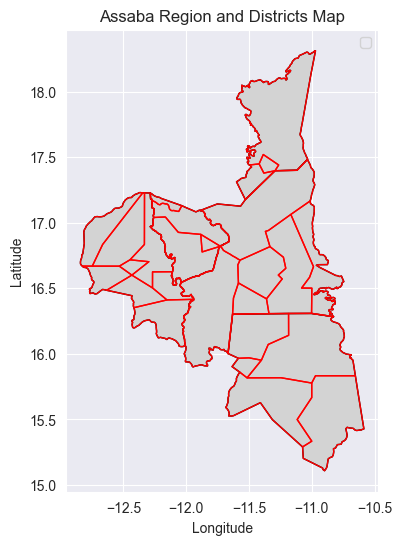

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (adjust the file path as needed)
districts_shapefile = "Datasets_Hackathon 1/Datasets_Hackathon/Admin_layers/Assaba_Districts_layer.shp"
regions_shapefile = "Datasets_Hackathon 1/Datasets_Hackathon/Admin_layers/Assaba_Region_layer.shp"

# Read the shapefiles
districts_gdf = gpd.read_file(districts_shapefile)
regions_gdf = gpd.read_file(regions_shapefile)

# Print basic information
print(districts_gdf.head())  # Display the first few rows
print(regions_gdf.head())

# Plot the shapefiles
fig, ax = plt.subplots(figsize=(10, 6))
regions_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", label="Regions")
districts_gdf.plot(ax=ax, color="none", edgecolor="red", linewidth=1, label="Districts")

# Add legend and title
plt.legend()
plt.title("Assaba Region and Districts Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


Fetching NDVI for 2010...
Fetching NDVI for 2011...
Fetching NDVI for 2012...
Fetching NDVI for 2013...
Fetching NDVI for 2014...
Fetching NDVI for 2015...
Fetching NDVI for 2016...
Fetching NDVI for 2017...
Fetching NDVI for 2018...
Fetching NDVI for 2019...
Fetching NDVI for 2020...
Fetching NDVI for 2021...
Fetching NDVI for 2022...
Fetching NDVI for 2023...
All NDVI data successfully fetched!


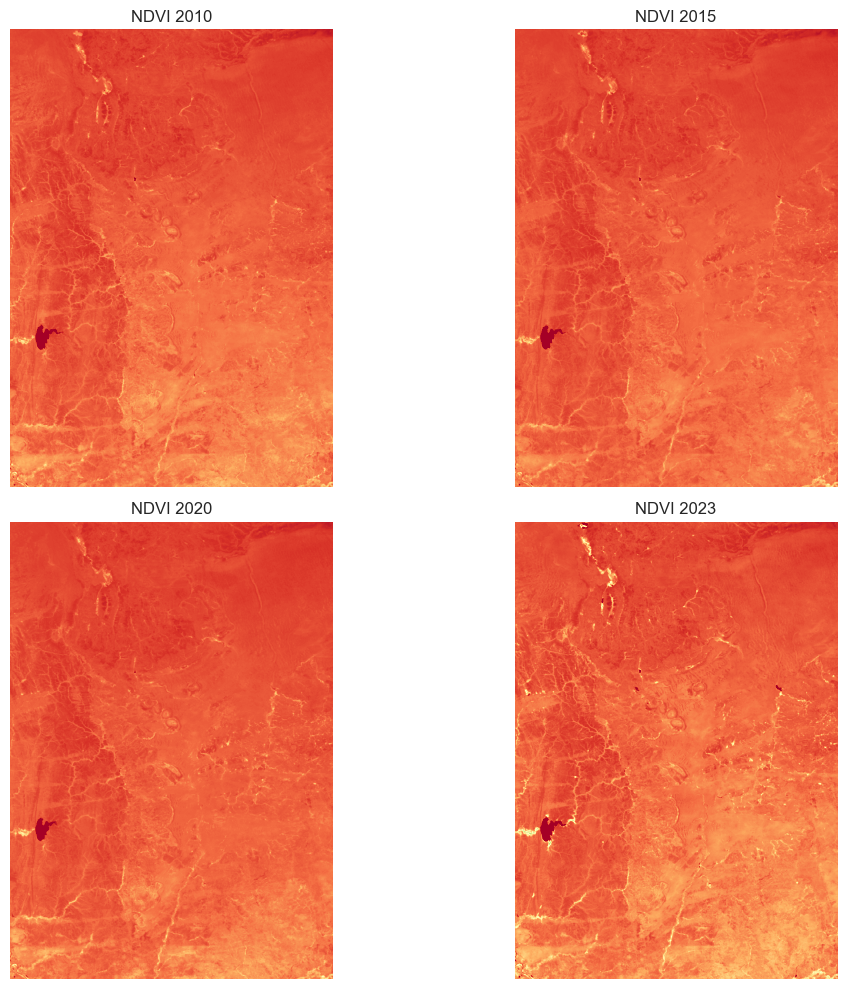

In [11]:
import ee
import geopandas as gpd
import json
import numpy as np
import matplotlib.pyplot as plt
import geemap
import requests
import tempfile
import os

# Authenticate & Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# 🔥 Convert timestamp columns to string (Fix)
for col in regions_gdf.select_dtypes(include=["datetime", "timedelta"]).columns:
    regions_gdf[col] = regions_gdf[col].astype(str)


# Convert to GeoJSON and create an Earth Engine FeatureCollection
geojson_dict = json.loads(regions_gdf.to_json())
region = ee.FeatureCollection(geojson_dict)

# Define year range
years = list(range(2010, 2024))

# Dictionary to store NDVI arrays per year
ndvi_data_by_year = {}

# Loop through each year and fetch NDVI
for year in years:
    print(f"Fetching NDVI for {year}...")

    # Filter NDVI data for the specific year
    ndvi_dataset = ee.ImageCollection("MODIS/006/MOD13Q1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .filterBounds(region) \
        .select("NDVI")

    # Compute the median NDVI for the year and clip to the region
    ndvi_image = ndvi_dataset.median().clip(region)

    # Get download URL
    url = ndvi_image.getDownloadURL({'scale': 250, 'region': region.geometry().bounds().getInfo(), 'format': 'NPY'})

    # Download the file using requests
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Create a temporary file
    fd, temp_path = tempfile.mkstemp(suffix=".npy")

    # Write the response content to the temp file
    with os.fdopen(fd, "wb") as tmp_file:
        tmp_file.write(response.content)

    # Load NumPy array from temp file
    ndvi_data = np.load(temp_path)

    # Remove temp file after loading
    os.remove(temp_path)

    # 🔥 Convert structured array to a regular NumPy array
    ndvi_array = ndvi_data['NDVI']  # Extract the NDVI band

    # Store NDVI in the dictionary
    ndvi_data_by_year[year] = ndvi_array

print("All NDVI data successfully fetched!")

# Plot NDVI for a few selected years (2010, 2015, 2020, 2023)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

selected_years = [2010, 2015, 2020, 2023]
for ax, year in zip(axes.flatten(), selected_years):
    ax.imshow(ndvi_data_by_year[year], cmap="RdYlGn", vmin=0, vmax=9000)
    ax.set_title(f"NDVI {year}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Fetching LST for 2010...
Fetching LST for 2011...
Fetching LST for 2012...
Fetching LST for 2013...
Fetching LST for 2014...
Fetching LST for 2015...
Fetching LST for 2016...
Fetching LST for 2017...
Fetching LST for 2018...
Fetching LST for 2019...
Fetching LST for 2020...
Fetching LST for 2021...
Fetching LST for 2022...
Fetching LST for 2023...
All LST data successfully fetched!


C:\Users\tilma\AppData\Local\Temp\ipykernel_18544\3616511624.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


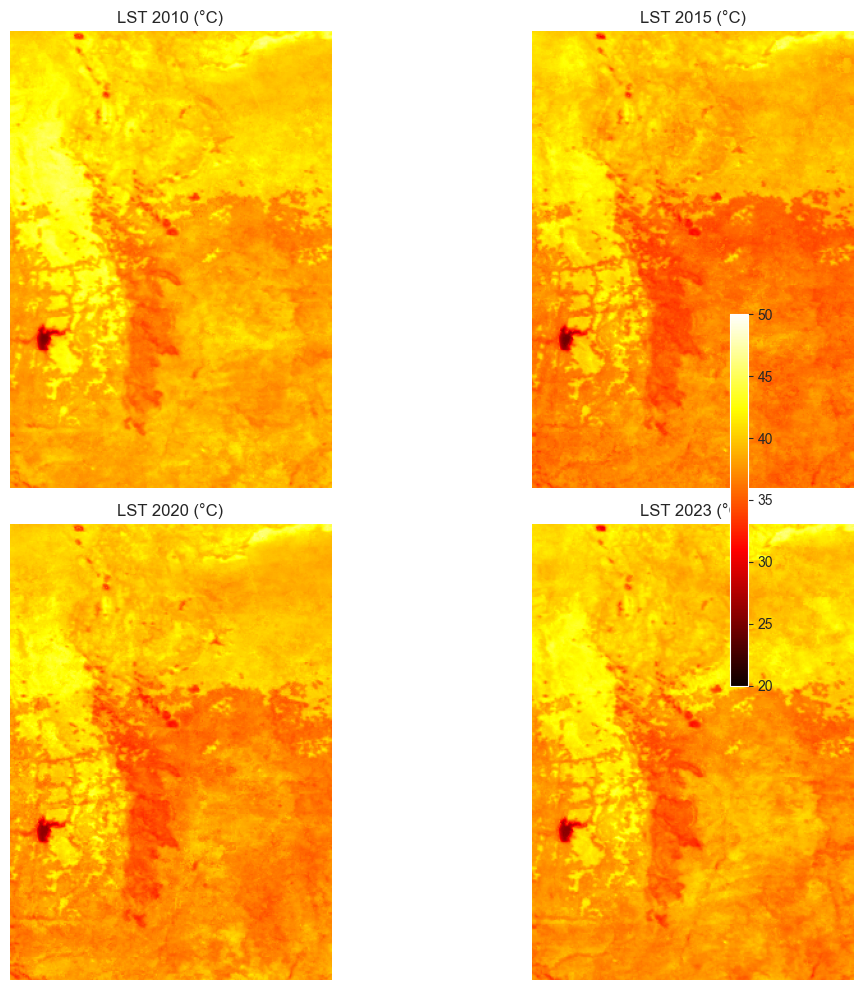

In [12]:
# Dictionary to store LST arrays per year
lst_data_by_year = {}
# Loop through each year and fetch LST
for year in years:
    print(f"Fetching LST for {year}...")

    # Load MODIS Land Surface Temperature Dataset (MOD11A2)
    lst_dataset = ee.ImageCollection("MODIS/061/MOD11A2") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .filterBounds(region) \
        .select("LST_Day_1km")  # Select daytime land surface temperature

    # Compute the median LST for the year and clip to the region
    lst_image = lst_dataset.median().clip(region)

    # Get download URL
    url = lst_image.getDownloadURL({'scale': 1000, 'region': region.geometry().bounds().getInfo(), 'format': 'NPY'})

    # Download the file using requests
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Create a temporary file
    fd, temp_path = tempfile.mkstemp(suffix=".npy")

    # Write the response content to the temp file
    with os.fdopen(fd, "wb") as tmp_file:
        tmp_file.write(response.content)

    # Load NumPy array from temp file
    lst_data = np.load(temp_path)

    # Remove temp file after loading
    os.remove(temp_path)

    # 🔥 Convert structured array to a regular NumPy array & apply MODIS LST scale factor
    lst_array = lst_data['LST_Day_1km'] * 0.02 - 273.15  # Convert to Celsius

    # Store LST in the dictionary
    lst_data_by_year[year] = lst_array

print("All LST data successfully fetched!")

# Plot LST for a few selected years (2010, 2015, 2020, 2023)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

selected_years = [2010, 2015, 2020, 2023]
for ax, year in zip(axes.flatten(), selected_years):
    img = ax.imshow(lst_data_by_year[year], cmap="hot", vmin=20, vmax=50)  # Adjust scale based on region
    ax.set_title(f"LST {year} (°C)")
    ax.axis("off")

plt.colorbar(img, ax=axes, fraction=0.02)
plt.tight_layout()
plt.show()

In [13]:
import rasterio
from rasterio.transform import from_bounds
import os

# Define the output folders
ndvi_output_folder = "NDVI_TIFFs"
lst_output_folder = "LST_TIFFs"

os.makedirs(ndvi_output_folder, exist_ok=True)
os.makedirs(lst_output_folder, exist_ok=True)

# Define bounding box (Assuming WGS84 projection, extracted from region bounds)
bounds = region.geometry().bounds().getInfo()['coordinates'][0]
minx, miny = bounds[0]
maxx, maxy = bounds[2]

# Get transform for raster
def get_transform(array_shape):
    return from_bounds(minx, miny, maxx, maxy, array_shape[1], array_shape[0])

# Function to save NumPy arrays as GeoTIFF
def save_array_to_tiff(array, output_path, transform):
    with rasterio.open(
        output_path, 'w', driver='GTiff',
        height=array.shape[0], width=array.shape[1], count=1,
        dtype=array.dtype, crs='EPSG:4326', transform=transform
    ) as dst:
        dst.write(array, 1)

# Save NDVI data as GeoTIFF
for year, ndvi_array in ndvi_data_by_year.items():
    output_tif = os.path.join(ndvi_output_folder, f"NDVI_{year}.tif")
    save_array_to_tiff(ndvi_array, output_tif, get_transform(ndvi_array.shape))
    print(f"Saved {output_tif}")

# Save LST data as GeoTIFF
for year, lst_array in lst_data_by_year.items():
    output_tif = os.path.join(lst_output_folder, f"LST_{year}.tif")
    save_array_to_tiff(lst_array, output_tif, get_transform(lst_array.shape))
    print(f"Saved {output_tif}")

print("All NDVI & LST data saved as GeoTIFFs successfully!")


Saved NDVI_TIFFs\NDVI_2010.tif
Saved NDVI_TIFFs\NDVI_2011.tif
Saved NDVI_TIFFs\NDVI_2012.tif
Saved NDVI_TIFFs\NDVI_2013.tif
Saved NDVI_TIFFs\NDVI_2014.tif
Saved NDVI_TIFFs\NDVI_2015.tif
Saved NDVI_TIFFs\NDVI_2016.tif
Saved NDVI_TIFFs\NDVI_2017.tif
Saved NDVI_TIFFs\NDVI_2018.tif
Saved NDVI_TIFFs\NDVI_2019.tif
Saved NDVI_TIFFs\NDVI_2020.tif
Saved NDVI_TIFFs\NDVI_2021.tif
Saved NDVI_TIFFs\NDVI_2022.tif
Saved NDVI_TIFFs\NDVI_2023.tif
Saved LST_TIFFs\LST_2010.tif
Saved LST_TIFFs\LST_2011.tif
Saved LST_TIFFs\LST_2012.tif
Saved LST_TIFFs\LST_2013.tif
Saved LST_TIFFs\LST_2014.tif
Saved LST_TIFFs\LST_2015.tif
Saved LST_TIFFs\LST_2016.tif
Saved LST_TIFFs\LST_2017.tif
Saved LST_TIFFs\LST_2018.tif
Saved LST_TIFFs\LST_2019.tif
Saved LST_TIFFs\LST_2020.tif
Saved LST_TIFFs\LST_2021.tif
Saved LST_TIFFs\LST_2022.tif
Saved LST_TIFFs\LST_2023.tif
All NDVI & LST data saved as GeoTIFFs successfully!


In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define folders where GeoTIFFs are stored
ndvi_folder = "NDVI_TIFFs"
lst_folder = "LST_TIFFs"

# Select years to visualize
selected_years = range(2010, 2024)

# Function to load a GeoTIFF file
def load_tiff(file_path):
    with rasterio.open(file_path) as dataset:
        array = dataset.read(1)  # Read first band
        profile = dataset.profile  # Metadata
    return array, profile

# Plot NDVI and LST for selected years
fig, axes = plt.subplots(len(selected_years), 2, figsize=(12, len(selected_years) * 5))

for i, year in enumerate(selected_years):
    # Define file paths
    ndvi_tif = os.path.join(ndvi_folder, f"NDVI_{year}.tif")
    lst_tif = os.path.join(lst_folder, f"LST_{year}.tif")

    # Load NDVI & LST
    if os.path.exists(ndvi_tif):
        ndvi_array, _ = load_tiff(ndvi_tif)
    else:
        ndvi_array = None  # Handle missing data

    if os.path.exists(lst_tif):
        lst_array, _ = load_tiff(lst_tif)
    else:
        lst_array = None  # Handle missing data

    # Plot NDVI
    if ndvi_array is not None:
        ax = axes[i, 0]
        img1 = ax.imshow(ndvi_array, cmap="RdYlGn", vmin=0, vmax=9000)
        ax.set_title(f"NDVI {year}")
        ax.axis("off")
        plt.colorbar(img1, ax=ax, fraction=0.02)

    # Plot LST
    if lst_array is not None:
        ax = axes[i, 1]
        img2 = ax.imshow(lst_array, cmap="hot", vmin=20, vmax=50)  # Adjust for region
        ax.set_title(f"LST {year} (°C)")
        ax.axis("off")
        plt.colorbar(img2, ax=ax, fraction=0.02)

plt.tight_layout()
plt.show()


In [14]:
import ee
import geopandas as gpd
import json
import numpy as np
import rasterio
from rasterio.transform import from_bounds
import requests
import tempfile
import os
# Define year range
years = list(range(2010, 2024))

# Output folder
pop_output_folder = "Population_TIFFs"
os.makedirs(pop_output_folder, exist_ok=True)

# Bounding box for region
bounds = region.geometry().bounds().getInfo()['coordinates'][0]
minx, miny = bounds[0]
maxx, maxy = bounds[2]

# Get raster transform
def get_transform(array_shape):
    return from_bounds(minx, miny, maxx, maxy, array_shape[1], array_shape[0])

# Function to save NumPy arrays as GeoTIFF
def save_array_to_tiff(array, output_path, transform):
    with rasterio.open(
        output_path, 'w', driver='GTiff',
        height=array.shape[0], width=array.shape[1], count=1,
        dtype=array.dtype, crs='EPSG:4326', transform=transform
    ) as dst:
        dst.write(array, 1)

# Dictionary to store population data
pop_data_by_year = {}

# Extract population density for each year
for year in years:
    print(f"Fetching Population Density for {year}...")

    # Load WorldPop dataset
    pop_dataset = ee.ImageCollection("WorldPop/GP/100m/pop") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .filterBounds(region)

    # Compute the median and clip to the region
    pop_image = pop_dataset.median().clip(region)

    # Get download URL
    url = pop_image.getDownloadURL({'scale': 100, 'region': region.geometry().bounds().getInfo(), 'format': 'NPY'})

    # Download the file
    response = requests.get(url)
    response.raise_for_status()

    # Create a temporary file
    fd, temp_path = tempfile.mkstemp(suffix=".npy")

    # Write response content to temp file
    with os.fdopen(fd, "wb") as tmp_file:
        tmp_file.write(response.content)

    # Load NumPy array
    pop_data = np.load(temp_path)

    # Remove temp file
    os.remove(temp_path)

    # Extract the band
    pop_array = pop_data['population']  # WorldPop uses 'population' band

    # Store data
    pop_data_by_year[year] = pop_array

    # Save as GeoTIFF
    output_tif = os.path.join(pop_output_folder, f"Population_{year}.tif")
    save_array_to_tiff(pop_array, output_tif, get_transform(pop_array.shape))
    print(f"Saved {output_tif}")

print("All Population Density data saved as GeoTIFFs successfully!")


Fetching Population Density for 2010...
Saved Population_TIFFs\Population_2010.tif
Fetching Population Density for 2011...
Saved Population_TIFFs\Population_2011.tif
Fetching Population Density for 2012...
Saved Population_TIFFs\Population_2012.tif
Fetching Population Density for 2013...
Saved Population_TIFFs\Population_2013.tif
Fetching Population Density for 2014...
Saved Population_TIFFs\Population_2014.tif
Fetching Population Density for 2015...
Saved Population_TIFFs\Population_2015.tif
Fetching Population Density for 2016...
Saved Population_TIFFs\Population_2016.tif
Fetching Population Density for 2017...
Saved Population_TIFFs\Population_2017.tif
Fetching Population Density for 2018...
Saved Population_TIFFs\Population_2018.tif
Fetching Population Density for 2019...
Saved Population_TIFFs\Population_2019.tif
Fetching Population Density for 2020...
Saved Population_TIFFs\Population_2020.tif
Fetching Population Density for 2021...


EEException: Expression evaluates to an image with no bands.

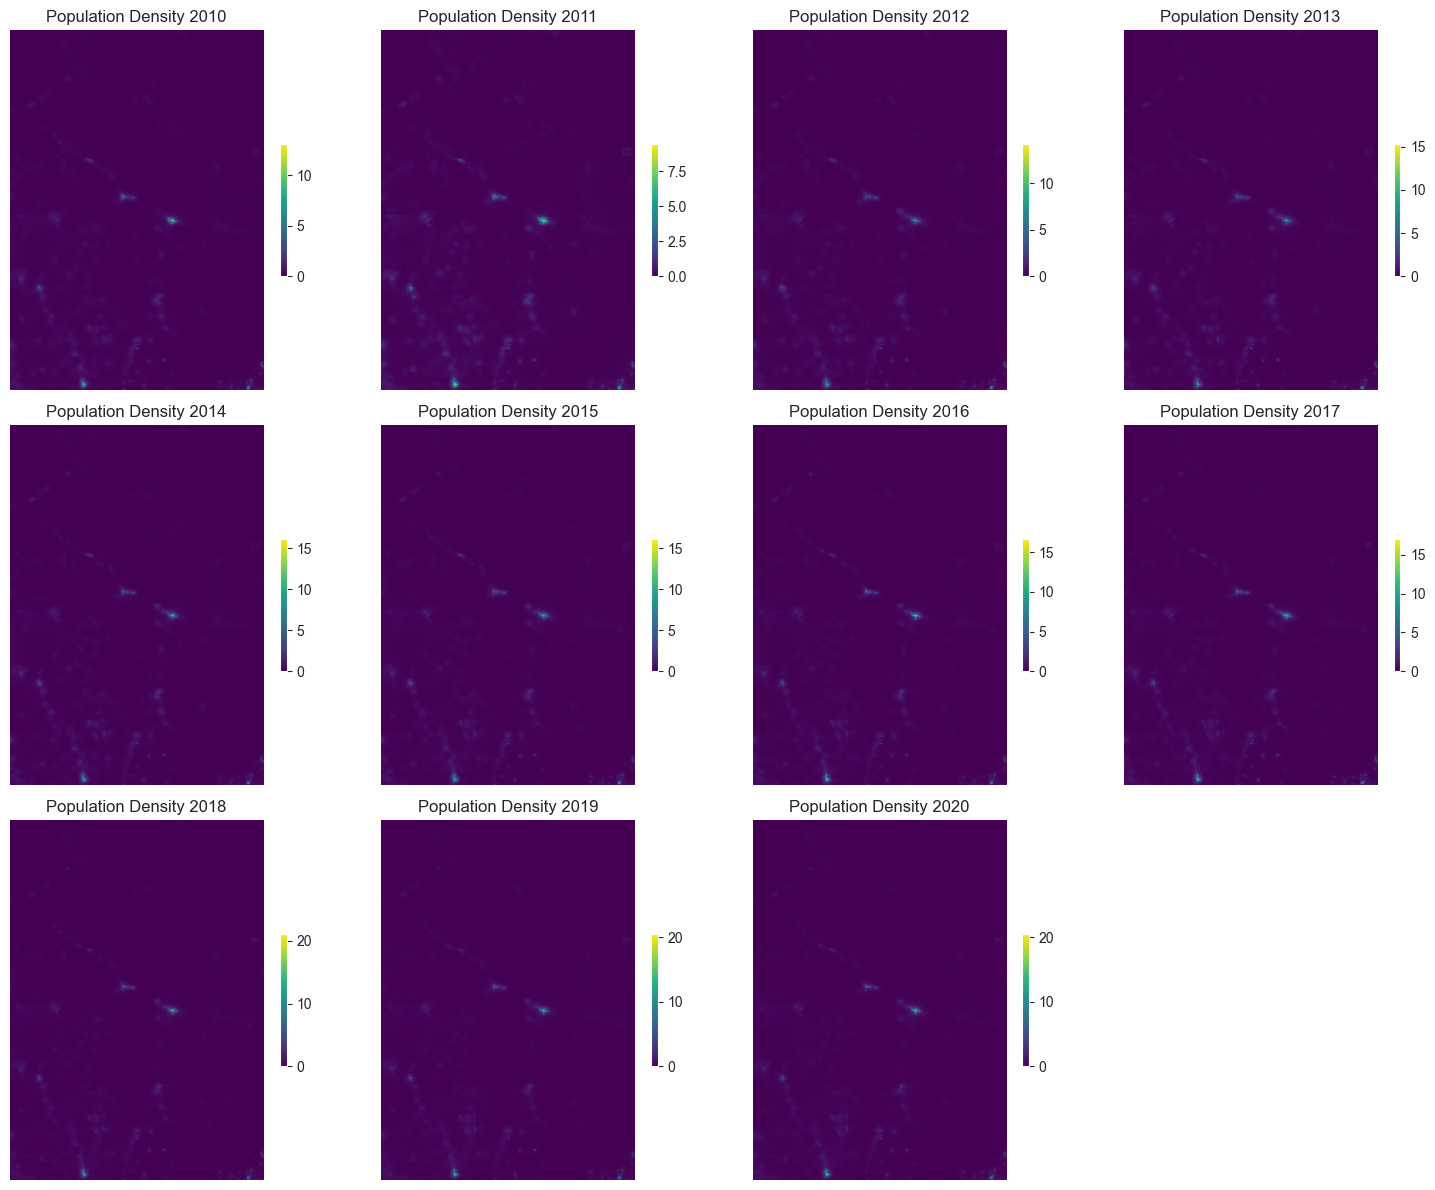

In [15]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define folder where population GeoTIFFs are stored
pop_folder = "Population_TIFFs"

# Get available GeoTIFF files
pop_files = sorted([f for f in os.listdir(pop_folder) if f.endswith(".tif")])

# Extract years from filenames (assuming format "Population_YYYY.tif")
years = [int(f.split("_")[1].split(".")[0]) for f in pop_files]

# Function to load a GeoTIFF file
def load_tiff(file_path):
    with rasterio.open(file_path) as dataset:
        array = dataset.read(1)  # Read first band
        profile = dataset.profile  # Metadata
    return array, profile

# Load all Population Density TIFFs into a dictionary
pop_data_by_year = {}
for year, file in zip(years, pop_files):
    pop_array, _ = load_tiff(os.path.join(pop_folder, file))
    pop_data_by_year[year] = pop_array

# Sort by year (just in case)
pop_data_by_year = dict(sorted(pop_data_by_year.items()))

# Select years for visualization
selected_years = list(pop_data_by_year.keys())  # Visualize all available years

# Create subplots dynamically
n_cols = 4  # Number of columns per row
n_rows = int(np.ceil(len(selected_years) / n_cols))  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each year's population density
for i, year in enumerate(selected_years):
    ax = axes[i]
    img = ax.imshow(pop_data_by_year[year], cmap="viridis", vmin=0, vmax=np.max(pop_data_by_year[year]))
    ax.set_title(f"Population Density {year}")
    ax.axis("off")
    plt.colorbar(img, ax=ax, fraction=0.02)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
